In [207]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [210]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

PassengerId = test["PassengerId"]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [211]:
full_data = [train, test]


#Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#Feature that tells whether a passenger had a cabin on the Titanic
train['Has_cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

#Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['isAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'isAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
    
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ''

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
                    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mile', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <=31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    
    

In [212]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [213]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_cabin,FamilySize,isAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


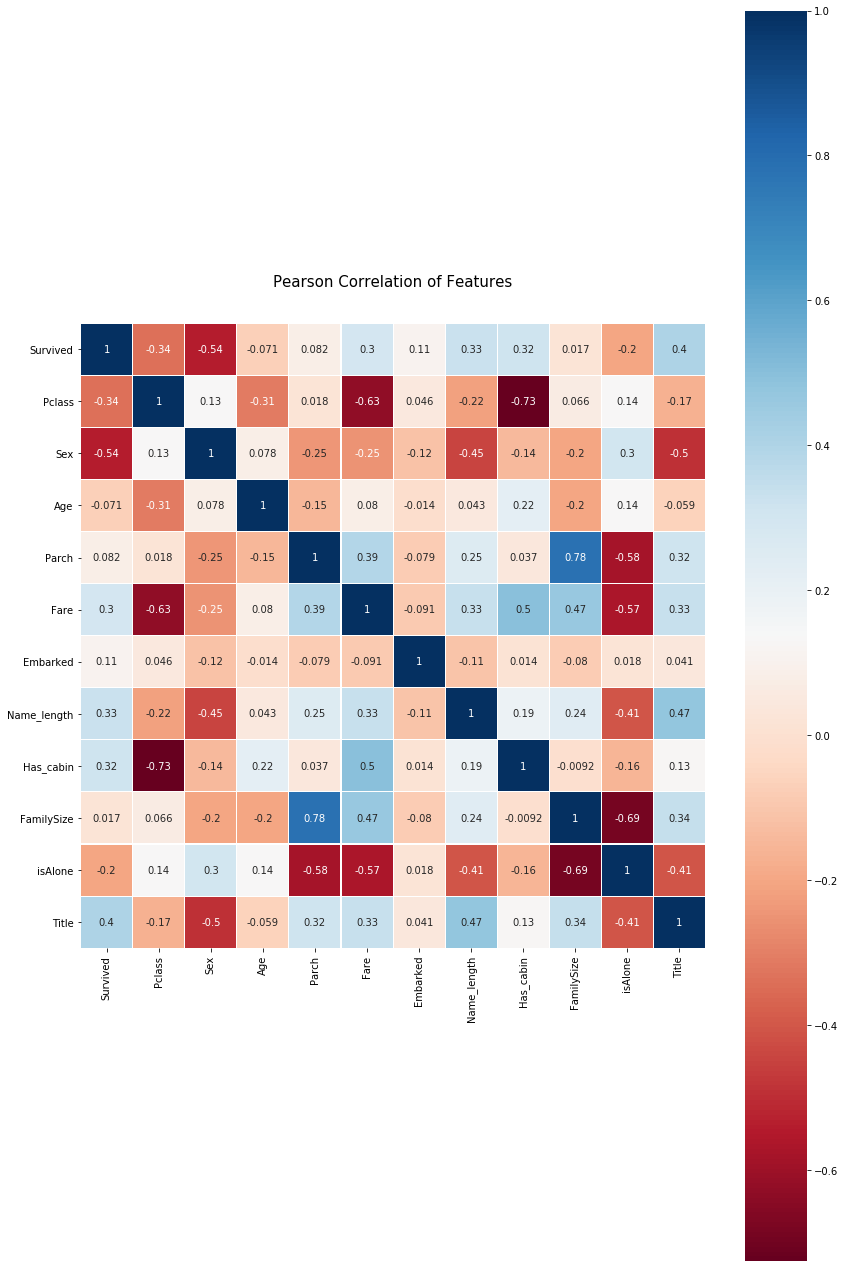

In [214]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 23))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, 
           square=True, linecolor='white', annot=True, cmap=colormap)

In [215]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [216]:
train_target = train.Survived
train_data = train.drop(columns='Survived')

test_data = test
test_target = pd.read_csv("titanic_test.csv")


X_train, X_test, y_test, y_test = train_test_split(train_data,
                                                   train_target,
                                                   test_size=0.3, 
                                                   random_state=17)

In [217]:
train2, valid, train_true, valid_true = train_test_split(X_train,
                                                         y_train,
                                                         test_size=0.5, 
                                                         random_state=0)

In [218]:
gbc_model = GridSearchCV(GradientBoostingClassifier(random_state=17), param_grid=gbc_params, cv=skf).fit(train2, train_true)
rfc_model = GridSearchCV(RandomForestClassifier(random_state=17), param_grid=rfc_params, cv=skf).fit(train2, train_true)
svc_model = GridSearchCV(SVC(random_state=17), param_grid=svc_params, cv=skf).fit(train2, train_true)
lr_model = GridSearchCV(LogisticRegression(random_state=17), param_grid=lr_params, cv=skf).fit(train2, train_true)

In [219]:
gbc_pred = gbc_model.predict(valid)
gbc_accuracy = accuracy_score(gbc_pred, valid_true)

rfc_pred = rfc_model.predict(valid)
rfc_accuracy = accuracy_score(rfc_pred, valid_true)

svc_pred = svc_model.predict(valid)
svc_accuracy = accuracy_score(svc_pred, valid_true)

lr_pred = lr_model.predict(valid)
lr_accuracy = accuracy_score(lr_pred, valid_true)

print(f'GradientBoostingClassifier: {np.round(gbc_accuracy, 2)};\n\
RandomForestClassifier: {np.round(rfc_accuracy, 2)};\n\
SVC: {np.round(svc_accuracy, 2)};\n\
LogisticRegression: {np.round(lr_accuracy, 2)}.')

GradientBoostingClassifier: 0.82;
RandomForestClassifier: 0.81;
SVC: 0.79;
LogisticRegression: 0.78.


In [220]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [221]:
gbc_model = GridSearchCV(GradientBoostingClassifier(random_state=17), param_grid=gbc_params, cv=skf).fit(train_data, train_target)
rfc_model = GridSearchCV(RandomForestClassifier(random_state=17), param_grid=rfc_params, cv=skf).fit(train_data, train_target)
svc_model = GridSearchCV(SVC(random_state=17), param_grid=svc_params, cv=skf).fit(train_data, train_target)
lr_model = GridSearchCV(LogisticRegression(random_state=17), param_grid=lr_params, cv=skf).fit(train_data, train_target)

In [251]:
models = [gbc_model, rfc_model, svc_model, lr_model]
meta_mtrx = np.empty((valid.shape[0], len(models)))  #number of objs, 4 algos

for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(valid)
    predicted = model.predict(X_test)
    
meta = XGBClassifier(n_estimators=40)
meta_model = meta.fit(meta_mtrx, valid_true)

meta_mtrx_test = np.empty((test_data.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test_data)
    
meta_predict = meta.predict(meta_mtrx_test)
accuracy_final = accuracy_score(meta_predict, test_target["Survived"])
print(f'Final result: {accuracy_final}.')

Final result: 0.8205741626794258.


In [242]:
def write_to_submission_file(meta_predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [249]:
res = write_to_submission_file(meta_predict, test_target["Survived"])